# Predictive coding of an $M$-dimensional signal in an $N$-dimensional network

Here, we derive and simulate dynamical equations for an N-dimensional network of neurons based on the derivations from the single neuron [1].

## Vectorizing the differential equations

Vectorizing the readout differential equation leads to

\begin{align}
    \dot{y}(t) = - y(t) + \textbf{D}^T\textbf{o}(t),  
\end{align}

where changes in $y(t)$ depend on the scalar product of a row vector $\textbf{D}^T = \frac{1}{N}(D_1, D_2, ..., D_N)$ and column vector $\textbf{o}(t)$ describing each neuron's spike train.

In [315]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from numpy import linalg as LA
#from cmaps import nice_cmap
from matplotlib.legend_handler import HandlerLine2D
import math
%matplotlib inline

" Parameters/containers "
VERBOSE = False                     # Printout
N       = 3                         # Number of neurons
M       = 2                         # Number of signal dimensions

T       = 100                       # Total duration
dt      = 0.001                     # Integration time step
time    = np.arange(0, T, dt)       # Time array
V       = np.zeros((N,len(time)))   # Membrane voltage
a       = 1.                        # Input amplitude
x       = np.zeros((M,len(time)))   # Constant input
stlen   = int((T/dt)/5)             # Duration of stimulus (20% of T = 4)
stm0    = int((T/dt)/2)             # Number of time steps for stimulus begin
stm1    = stm0+stlen                # Number of time steps for stimulus end (stm1-stm0==stmlen)
#x[:,stm0:stm1] = a                  # Offset
#x       = a*np.cumsum(rand.normal(0.0,0.01,(M, len(time))), axis=1)
x[0,:]  = np.cos(time)
x[1,:]  = np.sin(time)
print(x.shape)
#x      += a*rand.normal(0.0,0.01,(M,len(time))) ## Adding white noise
#x       = np.abs(x) 
y       = np.zeros((M,len(time)))   # Decoder
o       = np.zeros((N,len(time)))   # Spikes
st      = []                        # Spike times + index
rate    = np.zeros((N,len(time)))   # Firing rate
mu      = 0.0001                    # Regularization constant
#D       = 0.1*np.ones((M,N))/N      # Random readout weights (normally distributed)
inh     = int(1.1*N)
#D[inh:] = -1. * D[inh:]
#D       = 0.1*rand.normal(.0, 1., (M,N))#/N
Dsigma  = 0.0
angles  = np.linspace(0, 2*np.pi, num=N, endpoint=False) + weight_noise*rand.normal(0.0,1.0, N)
Dlen    = 0.1*(weight_noise*rand.normal(0.0,1.0, N)+1.0)
D       = Dlen*np.array([np.cos(angles),np.sin(angles)])
W       = (D.T).dot(D) + mu*np.eye(N)
if VERBOSE:
    evals, evecs = LA.eigh(W)
    print("Recurrent weights:", W)
    print("Readout weights:", D)
    print("Spectral radius:", evals)
Thr     = np.diag((D.T).dot(D))/2 + (mu/2)*np.ones(N)      # Threshold
decay   = 1.                        # Decay constant
if VERBOSE:
    print("Threshold:", Thr)    

" Voltage ODE "
def dV(i, spike):
    return - V[:,i] + (D.T).dot((x[:,i]+(x[:,i+1]-x[:,i])/dt)) - W.dot(spike)/dt

" Decoder ODE "
def dy(i, spike):
    return - y[:,i] + D.dot(spike)/dt
" Rate ODE "
def dr(i, spike):
    return - rate[:,i] + spike/dt

" List difference function "
def diff(a):
    return [a[i+1]-a[i] for i in range(len(a)-1)]

" Randomly choose one spike "
def rand_one(array):
    return rand.choice(np.ravel(np.nonzero(array)), 1)[0]

" Update step "
def step(i):
    if np.sum(o[:,i] > 0):
        st.append(t)
    " Potential (Euler) "
    V[:,i+1] = V[:,i] + dt * dV(i, o[:,i])   
    " Check spikes "    
    o[:,i+1] = (V[:,i+1] > Thr)
    if np.sum(o[:,i+1])>0:
        specfl = rand_one(o[:,i+1])
        o[:, i+1] = np.eye(N)[specfl]
    " Decoder (Euler) "
    y[:,i+1] = y[:,i] + dt * dy(i, o[:,i+1])
    " Estimate firing rate (Euler) "
    rate[:,i+1] = rate[:,i] + dt * dr(i, o[:,i+1])
    
" Simulation "
for i,t in enumerate(time[:-1]):
    if math.fmod(t,10)==0:
        print("t:",t)
    step(i)
    if np.sum(o[:,i])>0 and VERBOSE:
        print("Spike time:", t, "@neuron", np.argmax(o[:,i])+1, np.sum(o[:,i]))
print("Spikes/time:", np.sum(o)/(N*T/2))
print("Mean inverse ISI:", 1./(N*np.mean(diff(st))))


(2, 100000)
t: 0.0
t: 10.0
t: 20.0
t: 30.0
t: 40.0
t: 50.0
t: 60.0
t: 70.0
t: 80.0
t: 90.0
Spikes/time: 14.96
Mean inverse ISI: 7.48205374536


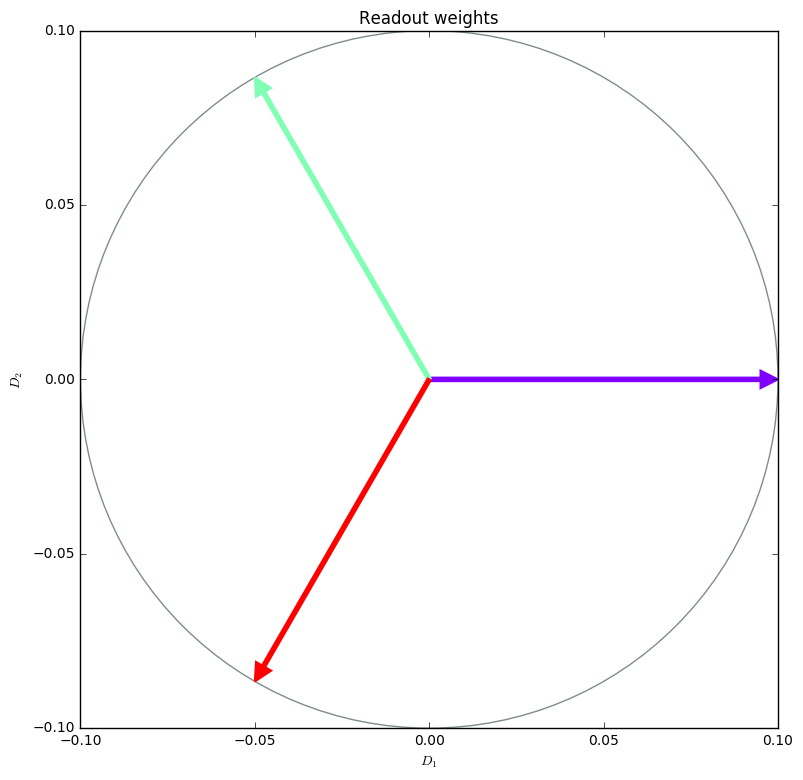

In [316]:
from matplotlib.patches import Circle, PathPatch
fig, ax = plt.subplots(figsize=(9, 9))
rmax = np.max(np.sqrt(D[0,:]**2+D[1,:]**2))
circle = Circle((0, 0), rmax, facecolor='none',
                edgecolor=(0, 0.1, 0.1), linewidth=1, alpha=0.5)
ax.add_patch(circle)
col = plt.get_cmap('rainbow', N)
for i in range(N):
    ax.arrow(0, 0, D[0,i], D[1,i], linewidth=1.5, head_width=rmax*0.05, head_length=rmax*0.05, length_includes_head=True, fc=col(i), ec=col(i))
plt.xlim([-rmax,rmax])
plt.ylim([-rmax,rmax])
plt.xlabel("$D_1$")
plt.ylabel("$D_2$")
plt.title("Readout weights")
plt.show()

In [312]:
" Plotting "
def plot_fig1():
    npanels = 4
    f, axarr = plt.subplots(npanels, sharex=True)
    K=3
    drawN = N
    lcols = int(math.ceil(drawN/3))
    Rsize = K*drawN+1
    excV = plt.get_cmap('Reds', int(0.8*Rsize))
    inhV = plt.get_cmap('Blues', int(0.2*Rsize))
    excR = plt.get_cmap('autumn', int(0.8*Rsize))
    inhR = plt.get_cmap('winter', int(0.2*Rsize))
    f.set_figheight(npanels*2)
    f.set_figwidth(npanels*3)
    plt.xticks(np.arange(0,1100,20))

    " Panel A: Decoding signal"
    for m in range(M):
        axarr[0].plot(time, x[m,:], c='k', label = 'Signal $x(t)$')
        axarr[0].plot(time, y[m,:], c='r', label ='Decoder $y(t)$')
    axarr[0].set_ylabel("Signal")
    #axarr[0].set_ylim([-0.1, a+0.1])
    axarr[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    " Panel B: Membrane potentials "
    for neuron in range(drawN):
        name = '$V_{'+str(neuron+1)+'}$'
        if neuron <= inh:
            axarr[1].plot(time, V[neuron,:], color=col(neuron), label = name)
        #else:
            #axarr[1].plot(time, V[neuron,:], color=inhV(Rsize-K*neuron), label = name)
    axarr[1].set_ylabel("Membrane potential")
    axarr[1].plot([0,T],[Thr,Thr], color='#bbbbbb')
    #axarr[1].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)

    " Panel C: Spike raster plot "
    for neuron in range(N):
        name = 'Neuron '+str(neuron+1)
        posy = (1+neuron)*o[neuron, o[neuron,:]==1]
        axarr[2].vlines(time[o[neuron,:]==1], posy-0.5, posy+0.5, label = name)
        #axarr[2].legend(handler_map={spikes: HandlerLine2D(numpoints=1)})
    #axarr[2].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    axarr[2].set_ylim([0, N+1])
    axarr[2].set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    axarr[2].set_yticks(np.arange(spacer,N+1,spacer))

    " Panel D: Firing rate estimates "
    for neuron in range(drawN):
        name = '$r_{'+str(neuron+1)+'}$'
        if neuron <= inh:
            axarr[3].plot(time, rate[neuron,:], color=col(neuron), label = name)
        #else:
            #axarr[3].plot(time, rate[neuron,:], color=inhR(K*neuron+10), label = name)
    axarr[3].set_ylabel("Firing rate")
    #axarr[3].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    #axarr[3].set_ylim([-1, 25.000])
    plt.xlabel("Time")
    
    return f, axarr

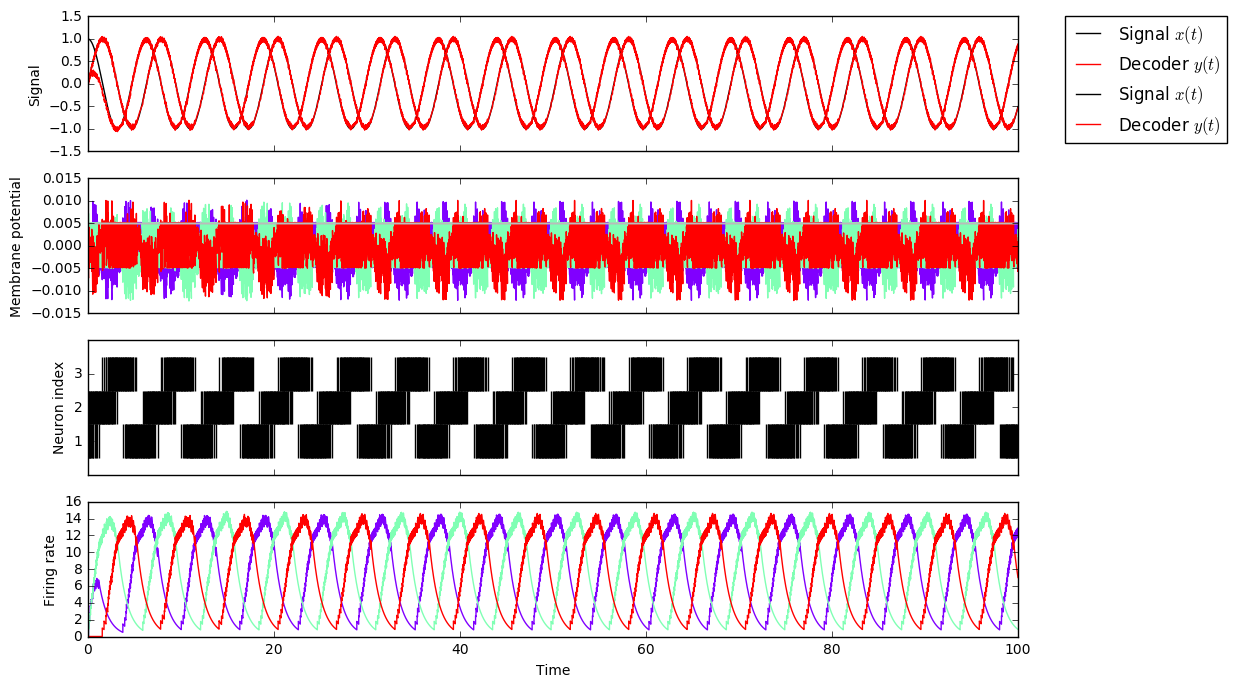

In [317]:
f, ax = plot_fig1()
plt.show()

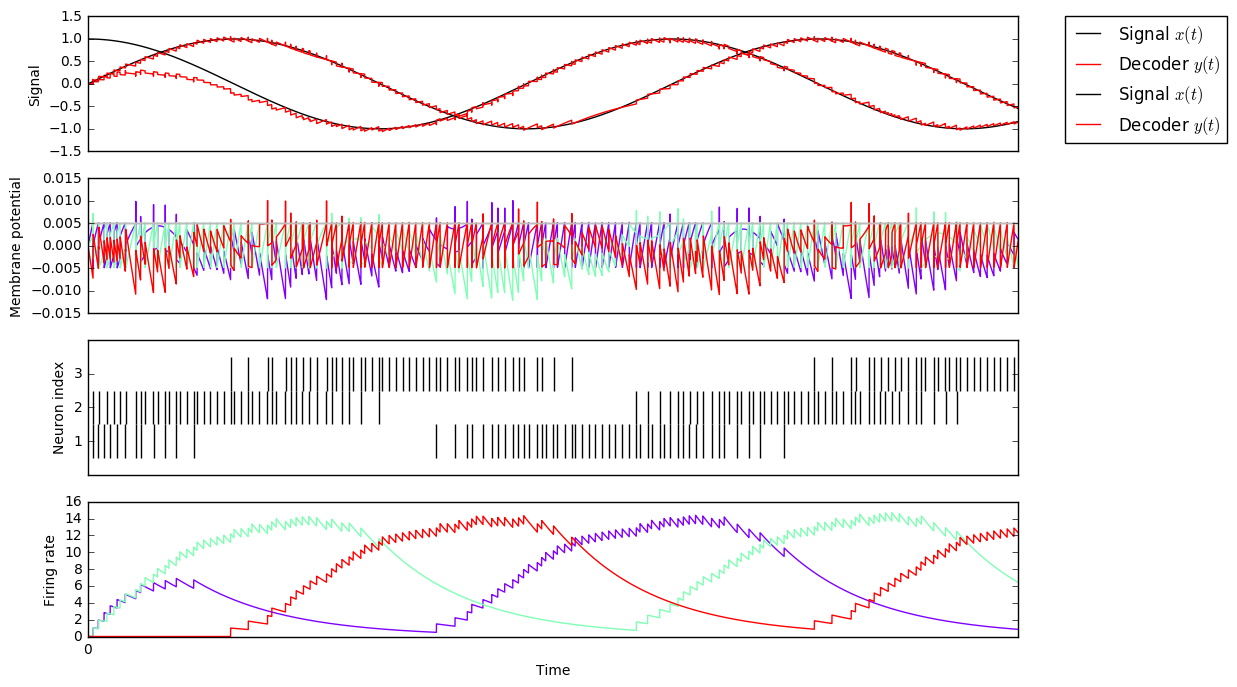

In [318]:
f, ax = plot_fig1()
plt.xlim([0, 10])
plt.show()


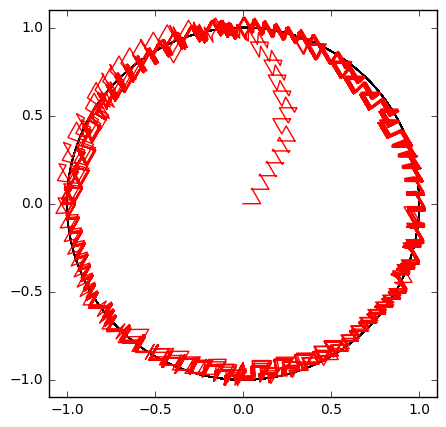

In [319]:
def plot_fig2():
    f = plt.figure(figsize=(5,5))
    plt.plot(x[0,:],x[1,:],'k-')
    plt.plot(y[0,:],y[1,:],'r-')
    return f

f = plot_fig2()
rad=np.max(np.max(x))+0.1*np.max(np.max(x))
plt.xlim((-rad,rad))
plt.ylim((-rad,rad))
plt.show()

In [245]:
means = []
rates = []
mus = []
" Goes through different values for D "
for trials in range(5):
    mu = 10 ** (trials-5) # -5, -4, -3, -2, -1
    mus.append(mu)
    V        = np.zeros((N,len(time)))    # Membrane potential
    y        = np.zeros(len(time))        # Decoder
    o        = np.zeros((N,len(time)))    # Spikes
    rate     = np.zeros((N,len(time)))    # Firing rate
    st = []
    for i,t in enumerate(time[:-1]):
        step(i)
    means.append(np.mean((x-y)**2))
    rates.append(np.mean(rate[:,hns:], axis=1)) # based on ISI
    print(mu, np.mean(rates[-1]), np.std(rates[-1]))
    #print("D: %1.2f\tInverse Mean ISI:%1.9f (%u samples)" % (D, 1./np.mean(diff(st)), len(st)))
minmu = mus[np.argmin(means)]
print("Minimum error:", np.min(means), "at Gamma", minmu)


1e-05 18.1447555395 0.0636062388415
0.0001 15.5065785467 0.0283847351414
0.001 6.50838924449 0.0275234819221
0.01 1.2985728033 0.00867460725716
0.1 0.402363270769 0.00534043606124
Minimum error: 0.00560981956666 at Gamma 1e-05


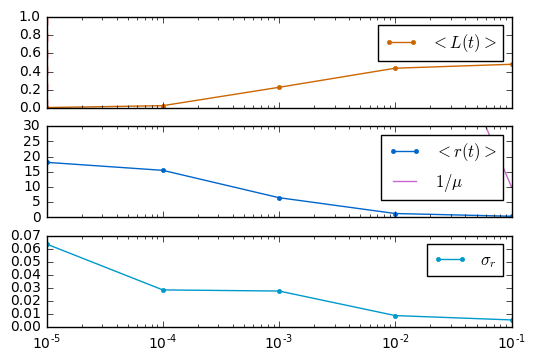

In [343]:
" Print/plot minimum error w.r.t. D "
f, axarr = plt.subplots(3, sharex=True)
axarr[0].semilogx(mus, means, '.-', color='#cc6600', label = '$<L(t)>$')
axarr[0].semilogx([minmu, minmu], [0.0, 1.0], 'r--')
axarr[0].legend()

axarr[1].semilogx(mus, np.mean(rates, axis=1), '.-', color='#0066cc', label = '$<r(t)>$')
axarr[1].semilogx(mus, a/np.asarray(mus), color='#cc66cc', label = '$1/\mu$')
axarr[1].set_ylim((0.0,30.0))
axarr[1].legend()

axarr[2].semilogx(mus, np.std(rates, axis=1), '.-', color='#0099cc', label = '$\sigma_r$')
axarr[2].legend()
plt.show()
